# Calculate Potential Energy Anomaly

A demonstration to calculate the Potential Energy Anomaly and demonstrate regional masking with MaskMaker (COAsT package)


### Relevant imports and filepath configuration

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import coast
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors  # colormap fiddling
import xarray as xr
import gc

/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/pydap/lib.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap.responses')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/gws/smf/j04/canari/conda-

In [6]:
data_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/OCN/yearly/1950"
fn_nemo_grid_t_dat = f"{data_path}/cv575o_1_mon__grid_T_votemper.nc"
fn_nemo_dom = "/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc"

fn_nemo_grid_t_dat_sal = f"{data_path}/cv575o_1_mon__grid_T_vosaline.nc"
config_t = "../config/example_nemo_grid_t.json"

### Loading data

In [7]:
t_data = xr.open_mfdataset([fn_nemo_grid_t_dat, fn_nemo_grid_t_dat_sal])

In [8]:
# Create a Gridded object and load in the data:
nemo = coast.Gridded(t_data, fn_nemo_dom, config=config_t)

### Subset the domain

We are not interested in the whole doman so it is computationally efficient to subset the data for the region of interest. Here we will look at the North Sea between (40N: 65N) and (-20E:15E).
We will great subset objects for both the t- and w-grids:

In [9]:
# Isel by time for demonstration purposes
nemo = nemo.isel(t_dim=[0,1])

In [10]:
# Isel by area for demonstration purposes
ind_2d = nemo.subset_indices(start=[40,-20], end=[65,15])
nemo_nwes = nemo.isel(y_dim=ind_2d[0], x_dim=ind_2d[1])

### Calculates Potential Energy Anomaly

The density and depth averaged density can be supplied within gridded_t as `density` and
`density_bar` DataArrays, respectively. If they are not supplied they will be calculated.
`density_bar` is calcuated using depth averages of temperature and salinity.



In [11]:
# # Compute a vertical max to exclude depths below 200m
Zd_mask, kmax, Ikmax = nemo_nwes.calculate_vertical_mask(200.)

In [12]:
# # Initiate a stratification diagnostics object
strat = coast.GriddedStratification(nemo_nwes)

In [13]:
strat.calc_pea(nemo_nwes, Zd_mask)

## make a plot

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': '16 Jan 1950: Potential Energy Anomaly (J / m^3)'}, xlabel='longitude', ylabel='latitude'>)

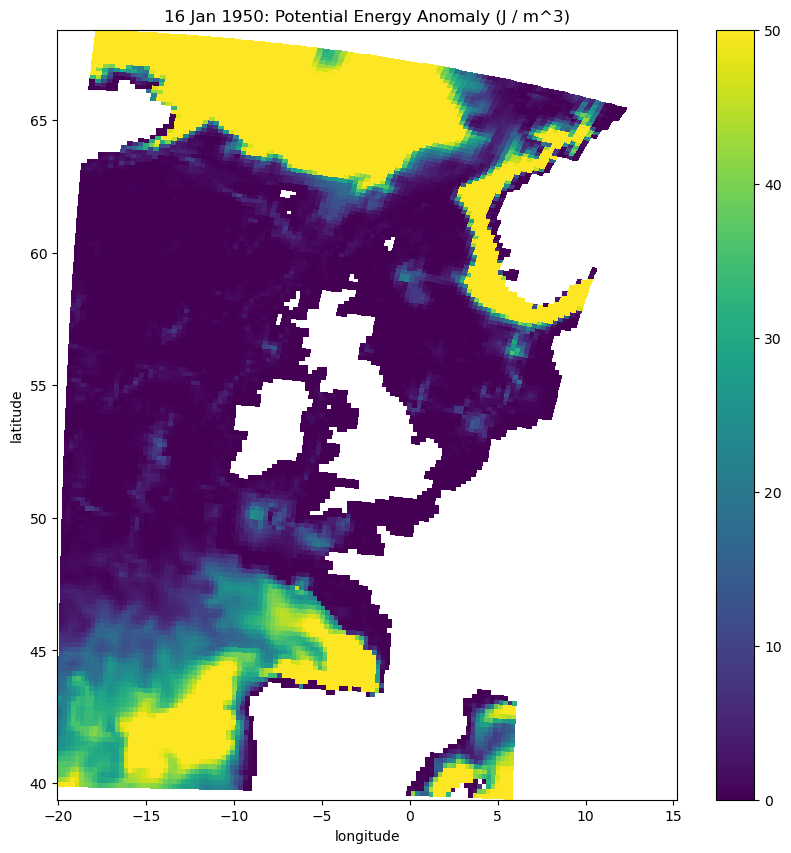

In [14]:
strat.quick_plot('PEA')

In [15]:
strat.dataset

<xarray.Dataset> Size: 433kB
Dimensions:    (t_dim: 2, y_dim: 175, x_dim: 103)
Coordinates:
    time       (t_dim) object 16B 1950-01-16 00:00:00 1950-02-16 00:00:00
    latitude   (y_dim, x_dim) float32 72kB 39.94 39.94 39.94 ... 64.94 64.88
    longitude  (y_dim, x_dim) float32 72kB -19.94 -19.69 -19.44 ... 14.72 15.0
Dimensions without coordinates: t_dim, y_dim, x_dim
Data variables:
    PEA        (t_dim, y_dim, x_dim) float64 288kB 48.71 49.41 50.41 ... nan nan

# Use MaskMaker to define regions and do regional analysis

MaskMaker can build a stack of boolean masks in an xarray dataset for regional analysis. For the NWS we can use some built-in regions.  

In [ ]:
mm = coast.MaskMaker()

# Define Regional Masks
regional_masks = []

# Define convenient aliases based on nemo data
lon = nemo_nwes.dataset.longitude.values
lat = nemo_nwes.dataset.latitude.values
bathy = nemo_nwes.dataset.bathymetry.values

# Add regional mask for whole domain
regional_masks.append(np.ones(lon.shape))

# Add regional mask for English Channel
regional_masks.append(mm.region_def_nws_north_north_sea(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_outer_shelf(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_norwegian_trench(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_english_channel(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_south_north_sea(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_off_shelf(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_irish_sea(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_kattegat(lon, lat, bathy))

region_names = ["whole domain", "north sea", "outer shelf", "norwegian trench",
                "english_channel", "southern north sea", "off shelf",
                "irish sea", "kattegat",]

Convert this list of masks into a dataset

In [ ]:
mask_list = mm.make_mask_dataset(lon, lat, regional_masks, region_names)

In [ ]:
mask_list

Inspect the mask with a `quick_plot()` method. 

In [ ]:
mm.quick_plot(mask_list)


# Regional analysis

Average stratification object over regions using the mask

In [ ]:
mask_means = (strat.dataset*mask_list.mask).mean(dim='x_dim').mean(dim='y_dim')

In [ ]:
mask_means

In [ ]:
# Plot timeseries per region

for count_region in range(mask_means.dims['dim_mask']):
    
    plt.plot( 
        mask_means.PEA.isel(dim_mask=count_region),
        label=mask_means.region_names[count_region].values,
        marker=".", linestyle='none')

plt.xlabel('time'); plt.ylabel('PEA')
plt.legend()